<a href="https://colab.research.google.com/github/MarawanEldeib/Cypher/blob/master/Copy_of_Anitej_Reproducibility_Project_Fruit_Detection_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# In cocoeval.py to get the thresholds of IoU @0.2 according to the paper
#Line 461
#stats[1] = _summarize(1, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 466
#stats[6] = _summarize(0, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 506
#self.iouThrs = np.linspace(.2, 1, int(np.round((1 - .2) / .05)) + 1, endpoint=True)

In [3]:
import torch
print(torch.__version__)

2.1.0+cu121


In [4]:
%%shell
/usr/local/lib/python3.10/dist-packages/pycocotools/cocoeval.py
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 458330, done.
remote: Counting objects: 100% (38789/38789), done.
remote: Compressing objects: 100% (1795/1795), done.
remote: Total 458330 (delta 36984), reused 38687 (delta 36936), pack-reused 419541
Receiving objects: 100% (458330/458330), 900.00 MiB | 33.31 MiB/s, done.
Resolving deltas: 100% (426072/426072), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import pycocotools
import os
new_dir = '/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/vision/references/detection'
os.makedirs(new_dir, exist_ok=True)
dir = r'/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/vision/references/detection'
os.chdir(dir)

In [63]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import PIL
from PIL import Image, ImageDraw
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
import utils
import os,sys
from torchvision import transforms as T
#import transforms as T
#import original_transforms as T2
import custom_transforms as T2

In [64]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["x", "y", "dx_new", "dy_new"]].values
    return boxes_array

In [65]:
# Define the datset class. This loads the path to the images and path to the csv file with dimensions of bounding boxes
class FruitDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):

        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.root))
        self.path_to_data_file = data_file


    def __getitem__(self, idx):

        # load images and bounding boxes

        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx][:-4])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [66]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/mangoes/train_images",
data_file= r"/content/drive/MyDrive/mangoes/combined_csv.csv")
dataset.__getitem__(1)

(<PIL.Image.Image image mode=RGB size=500x500>,
 {'boxes': tensor([[273.0000, 344.0000, 320.1590, 391.1590],
          [248.0000, 356.0000, 295.1590, 403.1590],
          [373.0000, 395.0000, 420.1590, 442.1590],
          [391.0000, 418.0000, 438.1590, 465.1590],
          [332.6316, 381.5789, 364.6316, 424.1710],
          [327.3684, 267.3684, 355.8804, 298.4180],
          [344.7368, 242.1053, 376.1000, 283.4323]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([1]),
  'area': tensor([2223.9680, 2223.9680, 2223.9680, 2223.9680, 1362.9443,  885.2867,
          1296.1459]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])})

In [67]:
def get_model(num_classes):

    #Selecting the pretrained VGG16 faster-RCNN as the backbone model
    #from torchvision.models import vgg16, VGG16_Weights
    #backbone = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

    backbone = torchvision.models.vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(sizes=(( 64, 128,256),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

    model = FasterRCNN(backbone,num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler)

    return model

In [85]:
class CustomCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target=None):
        for t in self.transforms:
            if isinstance(t, (T2.RandomHorizontalFlip, T2.Resize)):  # Add T2.RandomGrayscale if using it
                img, target = t(img, target)
            else:
                img = t(img)
        return img, target

def get_transform(train):

    transform_list = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transform_list.append(T.ToTensor())
    if train:
      #Flip transform- images are flipped with 0.5 probability
      transform_list.append(T2.RandomHorizontalFlip(0.5))
      #Scale transform to 300x300
      transform_list.append(T2.Resize(size = 300))

      #Convert images to grayscale with a probability of 0.2
      #transform_list.append(T.RandomGrayscale(0.2))

    return CustomCompose(transform_list)

In [83]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [86]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/mangoes/train_images",
data_file= r"/content/drive/MyDrive/mangoes/combined_csv.csv",transforms = get_transform(train=True))

dataset_test = FruitDataset(root= r"/content/drive/MyDrive/mangoes/test_images",
          data_file= r"/content/drive/MyDrive/mangoes/combined_test/combined_test_csv.csv",
               transforms = get_transform(train=False))
#Random seed value
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

#Choose a subset from the training dataset
dataset_subset = torch.utils.data.Subset(dataset,indices[:500])

data_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1,collate_fn=utils.collate_fn)

print("Train dataset: ", len(data_loader), " \nTest dataset length",len(data_loader_test))
dataset.__getitem__(1)

Train dataset:  500  
Test dataset length 250


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[0.3473, 0.3268, 0.3525,  ..., 0.3041, 0.3059, 0.3063],
          [0.3660, 0.3529, 0.3268,  ..., 0.2915, 0.2863, 0.2928],
          [0.3490, 0.3373, 0.3464,  ..., 0.3107, 0.3085, 0.3050],
          ...,
          [0.1359, 0.1216, 0.1115,  ..., 0.2074, 0.1830, 0.2061],
          [0.1386, 0.1255, 0.0967,  ..., 0.2118, 0.1922, 0.1817],
          [0.1368, 0.1255, 0.1024,  ..., 0.2065, 0.1856, 0.1634]],
 
         [[0.2932, 0.2941, 0.2989,  ..., 0.2519, 0.2484, 0.2571],
          [0.2941, 0.2902, 0.2941,  ..., 0.2431, 0.2431, 0.2444],
          [0.2993, 0.2863, 0.2946,  ..., 0.2514, 0.2549, 0.2558],
          ...,
          [0.1085, 0.0889, 0.0902,  ..., 0.1991, 0.1804, 0.1756],
          [0.1085, 0.0941, 0.0837,  ..., 0.1948, 0.1804, 0.1595],
          [0.1224, 0.0980, 0.0898,  ..., 0.2013, 0.1804, 0.1564]],
 
         [[0.3730, 0.3778, 0.3795,  ..., 0.3303, 0.3346, 0.3216],
          [0.3712, 0.3765, 0.3830,  ..., 0.3320, 0.3255, 0.3216],
          [0.3656, 0.3686, 0.3778,  ...,

In [71]:
#Check if GPU is available
torch.cuda.is_available()

True

In [87]:
device = torch.device('cuda:0')
# Our dataset has two classes only - mango and not mango
num_classes = 2
# Get the model using our helper function
model = get_model(num_classes)
# Move model to the right device
model.to(device)
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,momentum=0.9, weight_decay=0.0005)
# A learning rate scheduler which decreases the learning rate by # 10x every 5 epochs. Change this value based on the dataset size
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
import os

# Number of epochs to train for
num_epochs = 20

for epoch in range(num_epochs):
    # Train for one epoch
    torch.cuda.empty_cache()
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)

    # Update the learning rate
    lr_scheduler.step()

    # Save the model every 2 epochs
    if (epoch % 2) == 0:
        save_path = r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500"
        # Create the directory if it does not exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)

    # Evaluate the model on test set every 2 epochs
    if (epoch % 2) == 0:
        evaluate(model, data_loader_test, device=device)

# Save the model after training
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)

# Evaluate on the test dataset after training
evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [0]  [  0/500]  eta: 0:05:44  lr: 0.000003  loss: 1.4535 (1.4535)  loss_classifier: 0.7044 (0.7044)  loss_box_reg: 0.0510 (0.0510)  loss_objectness: 0.6906 (0.6906)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 0.6892  data: 0.3219  max mem: 12429


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [0]  [499/500]  eta: 0:00:00  lr: 0.001000  loss: 0.1091 (0.4559)  loss_classifier: 0.0311 (0.1838)  loss_box_reg: 0.0141 (0.0365)  loss_objectness: 0.0319 (0.2250)  loss_rpn_box_reg: 0.0047 (0.0105)  time: 0.2719  data: 0.0035  max mem: 12597
Epoch: [0] Total time: 0:02:25 (0.2918 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:04  model_time: 0.1503 (0.1503)  evaluator_time: 0.0043 (0.0043)  time: 0.2585  data: 0.1021  max mem: 12597
Test:  [100/250]  eta: 0:00:17  model_time: 0.0973 (0.0986)  evaluator_time: 0.0025 (0.0094)  time: 0.1214  data: 0.0106  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1025 (0.0997)  evaluator_time: 0.0011 (0.0084)  time: 0.1130  data: 0.0039  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1013 (0.1003)  evaluator_time: 0.0033 (0.0085)  time: 0.1239  data: 0.0113  max mem: 12597
Test: Total time: 0:00:29 (0.1167 s / it)
Averaged stats: model_time: 0.1013 (0.1003)  evaluator_time: 0.0033 (0.0085)
Ac

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [1]  [  0/500]  eta: 0:04:07  lr: 0.001000  loss: 0.2778 (0.2778)  loss_classifier: 0.0760 (0.0760)  loss_box_reg: 0.1210 (0.1210)  loss_objectness: 0.0653 (0.0653)  loss_rpn_box_reg: 0.0155 (0.0155)  time: 0.4954  data: 0.1980  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [1]  [499/500]  eta: 0:00:00  lr: 0.001000  loss: 0.0331 (0.1732)  loss_classifier: 0.0164 (0.0590)  loss_box_reg: 0.0000 (0.0683)  loss_objectness: 0.0086 (0.0366)  loss_rpn_box_reg: 0.0000 (0.0093)  time: 0.2758  data: 0.0056  max mem: 12597
Epoch: [1] Total time: 0:02:17 (0.2754 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [2]  [  0/500]  eta: 0:03:44  lr: 0.001000  loss: 0.3466 (0.3466)  loss_classifier: 0.1021 (0.1021)  loss_box_reg: 0.1848 (0.1848)  loss_objectness: 0.0418 (0.0418)  loss_rpn_box_reg: 0.0180 (0.0180)  time: 0.4483  data: 0.1816  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [2]  [499/500]  eta: 0:00:00  lr: 0.001000  loss: 0.0679 (0.1643)  loss_classifier: 0.0130 (0.0500)  loss_box_reg: 0.0269 (0.0838)  loss_objectness: 0.0098 (0.0233)  loss_rpn_box_reg: 0.0032 (0.0072)  time: 0.2795  data: 0.0048  max mem: 12597
Epoch: [2] Total time: 0:02:17 (0.2759 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:04  model_time: 0.1506 (0.1506)  evaluator_time: 0.0039 (0.0039)  time: 0.2598  data: 0.1034  max mem: 12597
Test:  [100/250]  eta: 0:00:18  model_time: 0.1007 (0.1020)  evaluator_time: 0.0014 (0.0091)  time: 0.1096  data: 0.0038  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1043 (0.1027)  evaluator_time: 0.0013 (0.0075)  time: 0.1151  data: 0.0040  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1042 (0.1030)  evaluator_time: 0.0016 (0.0067)  time: 0.1129  data: 0.0038  max mem: 12597
Test: Total time: 0:00:29 (0.1172 s / it)
Averaged stats: model_time: 0.1042 (0.1030)  evaluator_time: 0.0016 (0.0067)
Ac

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [3]  [  0/500]  eta: 0:04:00  lr: 0.001000  loss: 0.3551 (0.3551)  loss_classifier: 0.0772 (0.0772)  loss_box_reg: 0.2206 (0.2206)  loss_objectness: 0.0454 (0.0454)  loss_rpn_box_reg: 0.0119 (0.0119)  time: 0.4805  data: 0.1996  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [3]  [499/500]  eta: 0:00:00  lr: 0.001000  loss: 0.1134 (0.1526)  loss_classifier: 0.0423 (0.0446)  loss_box_reg: 0.0368 (0.0833)  loss_objectness: 0.0157 (0.0188)  loss_rpn_box_reg: 0.0039 (0.0059)  time: 0.2731  data: 0.0038  max mem: 12597
Epoch: [3] Total time: 0:02:18 (0.2763 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [4]  [  0/500]  eta: 0:04:08  lr: 0.001000  loss: 0.1690 (0.1690)  loss_classifier: 0.0566 (0.0566)  loss_box_reg: 0.0856 (0.0856)  loss_objectness: 0.0188 (0.0188)  loss_rpn_box_reg: 0.0079 (0.0079)  time: 0.4975  data: 0.2067  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [4]  [499/500]  eta: 0:00:00  lr: 0.001000  loss: 0.0308 (0.1429)  loss_classifier: 0.0107 (0.0388)  loss_box_reg: 0.0164 (0.0840)  loss_objectness: 0.0017 (0.0148)  loss_rpn_box_reg: 0.0015 (0.0052)  time: 0.2724  data: 0.0032  max mem: 12597
Epoch: [4] Total time: 0:02:18 (0.2769 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:07  model_time: 0.1525 (0.1525)  evaluator_time: 0.0043 (0.0043)  time: 0.2706  data: 0.1122  max mem: 12597
Test:  [100/250]  eta: 0:00:16  model_time: 0.0989 (0.0999)  evaluator_time: 0.0018 (0.0045)  time: 0.1166  data: 0.0103  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1029 (0.1007)  evaluator_time: 0.0010 (0.0041)  time: 0.1108  data: 0.0036  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1011 (0.1010)  evaluator_time: 0.0023 (0.0041)  time: 0.1209  data: 0.0119  max mem: 12597
Test: Total time: 0:00:28 (0.1135 s / it)
Averaged stats: model_time: 0.1011 (0.1010)  evaluator_time: 0.0023 (0.0041)
Ac

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [5]  [  0/500]  eta: 0:04:54  lr: 0.000100  loss: 0.3204 (0.3204)  loss_classifier: 0.0868 (0.0868)  loss_box_reg: 0.2069 (0.2069)  loss_objectness: 0.0129 (0.0129)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 0.5893  data: 0.2777  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [5]  [499/500]  eta: 0:00:00  lr: 0.000100  loss: 0.0670 (0.1276)  loss_classifier: 0.0178 (0.0341)  loss_box_reg: 0.0497 (0.0768)  loss_objectness: 0.0022 (0.0128)  loss_rpn_box_reg: 0.0008 (0.0040)  time: 0.2758  data: 0.0046  max mem: 12597
Epoch: [5] Total time: 0:02:18 (0.2776 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [6]  [  0/500]  eta: 0:05:17  lr: 0.000100  loss: 0.0470 (0.0470)  loss_classifier: 0.0113 (0.0113)  loss_box_reg: 0.0299 (0.0299)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.6347  data: 0.3480  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [6]  [499/500]  eta: 0:00:00  lr: 0.000100  loss: 0.1248 (0.1268)  loss_classifier: 0.0274 (0.0330)  loss_box_reg: 0.0722 (0.0778)  loss_objectness: 0.0032 (0.0121)  loss_rpn_box_reg: 0.0021 (0.0038)  time: 0.2760  data: 0.0037  max mem: 12597
Epoch: [6] Total time: 0:02:18 (0.2775 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:07  model_time: 0.1502 (0.1502)  evaluator_time: 0.0044 (0.0044)  time: 0.2699  data: 0.1136  max mem: 12597
Test:  [100/250]  eta: 0:00:17  model_time: 0.1007 (0.1001)  evaluator_time: 0.0016 (0.0081)  time: 0.1093  data: 0.0037  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1045 (0.1014)  evaluator_time: 0.0018 (0.0070)  time: 0.1172  data: 0.0055  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1027 (0.1018)  evaluator_time: 0.0020 (0.0063)  time: 0.1121  data: 0.0036  max mem: 12597
Test: Total time: 0:00:28 (0.1158 s / it)
Averaged stats: model_time: 0.1027 (0.1018)  evaluator_time: 0.0020 (0.0063)
Ac

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [7]  [  0/500]  eta: 0:04:23  lr: 0.000100  loss: 0.3109 (0.3109)  loss_classifier: 0.0780 (0.0780)  loss_box_reg: 0.1842 (0.1842)  loss_objectness: 0.0387 (0.0387)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 0.5275  data: 0.2304  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [7]  [499/500]  eta: 0:00:00  lr: 0.000100  loss: 0.0919 (0.1263)  loss_classifier: 0.0180 (0.0330)  loss_box_reg: 0.0518 (0.0777)  loss_objectness: 0.0044 (0.0119)  loss_rpn_box_reg: 0.0021 (0.0038)  time: 0.2762  data: 0.0056  max mem: 12597
Epoch: [7] Total time: 0:02:18 (0.2769 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [8]  [  0/500]  eta: 0:03:47  lr: 0.000100  loss: 0.0398 (0.0398)  loss_classifier: 0.0287 (0.0287)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0111 (0.0111)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4552  data: 0.1868  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [8]  [499/500]  eta: 0:00:00  lr: 0.000100  loss: 0.0705 (0.1248)  loss_classifier: 0.0179 (0.0321)  loss_box_reg: 0.0548 (0.0770)  loss_objectness: 0.0040 (0.0121)  loss_rpn_box_reg: 0.0016 (0.0037)  time: 0.2804  data: 0.0070  max mem: 12597
Epoch: [8] Total time: 0:02:18 (0.2776 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:06  model_time: 0.1507 (0.1507)  evaluator_time: 0.0041 (0.0041)  time: 0.2680  data: 0.1115  max mem: 12597
Test:  [100/250]  eta: 0:00:17  model_time: 0.1001 (0.1001)  evaluator_time: 0.0013 (0.0065)  time: 0.1093  data: 0.0043  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1018 (0.1010)  evaluator_time: 0.0011 (0.0057)  time: 0.1126  data: 0.0047  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1036 (0.1014)  evaluator_time: 0.0016 (0.0050)  time: 0.1114  data: 0.0037  max mem: 12597
Test: Total time: 0:00:28 (0.1141 s / it)
Averaged stats: model_time: 0.1036 (0.1014)  evaluator_time: 0.0016 (0.0050)
Ac

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [9]  [  0/500]  eta: 0:04:01  lr: 0.000100  loss: 0.0006 (0.0006)  loss_classifier: 0.0004 (0.0004)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.4830  data: 0.2090  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [9]  [499/500]  eta: 0:00:00  lr: 0.000100  loss: 0.1391 (0.1235)  loss_classifier: 0.0272 (0.0319)  loss_box_reg: 0.0904 (0.0757)  loss_objectness: 0.0102 (0.0121)  loss_rpn_box_reg: 0.0034 (0.0037)  time: 0.2789  data: 0.0058  max mem: 12597
Epoch: [9] Total time: 0:02:18 (0.2776 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [10]  [  0/500]  eta: 0:04:12  lr: 0.000010  loss: 0.2313 (0.2313)  loss_classifier: 0.0529 (0.0529)  loss_box_reg: 0.1448 (0.1448)  loss_objectness: 0.0239 (0.0239)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 0.5060  data: 0.2343  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [10]  [499/500]  eta: 0:00:00  lr: 0.000010  loss: 0.0685 (0.1202)  loss_classifier: 0.0173 (0.0314)  loss_box_reg: 0.0424 (0.0739)  loss_objectness: 0.0039 (0.0113)  loss_rpn_box_reg: 0.0023 (0.0036)  time: 0.2780  data: 0.0045  max mem: 12597
Epoch: [10] Total time: 0:02:19 (0.2782 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:07  model_time: 0.1527 (0.1527)  evaluator_time: 0.0045 (0.0045)  time: 0.2686  data: 0.1095  max mem: 12597
Test:  [100/250]  eta: 0:00:17  model_time: 0.1010 (0.1001)  evaluator_time: 0.0017 (0.0074)  time: 0.1093  data: 0.0038  max mem: 12597
Test:  [200/250]  eta: 0:00:05  model_time: 0.1035 (0.1011)  evaluator_time: 0.0013 (0.0062)  time: 0.1165  data: 0.0069  max mem: 12597
Test:  [249/250]  eta: 0:00:00  model_time: 0.1052 (0.1017)  evaluator_time: 0.0018 (0.0056)  time: 0.1135  data: 0.0042  max mem: 12597
Test: Total time: 0:00:28 (0.1156 s / it)
Averaged stats: model_time: 0.1052 (0.1017)  evaluator_time: 0.0018 (0.0056)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [11]  [  0/500]  eta: 0:04:31  lr: 0.000010  loss: 0.1151 (0.1151)  loss_classifier: 0.0444 (0.0444)  loss_box_reg: 0.0279 (0.0279)  loss_objectness: 0.0413 (0.0413)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.5435  data: 0.2503  max mem: 12597


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [11]  [499/500]  eta: 0:00:00  lr: 0.000010  loss: 0.0432 (0.1207)  loss_classifier: 0.0160 (0.0317)  loss_box_reg: 0.0290 (0.0741)  loss_objectness: 0.0054 (0.0114)  loss_rpn_box_reg: 0.0017 (0.0035)  time: 0.2799  data: 0.0050  max mem: 12601
Epoch: [11] Total time: 0:02:18 (0.2776 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [12]  [  0/500]  eta: 0:04:18  lr: 0.000010  loss: 0.3377 (0.3377)  loss_classifier: 0.1080 (0.1080)  loss_box_reg: 0.1959 (0.1959)  loss_objectness: 0.0238 (0.0238)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 0.5164  data: 0.2390  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [12]  [499/500]  eta: 0:00:00  lr: 0.000010  loss: 0.0332 (0.1207)  loss_classifier: 0.0091 (0.0317)  loss_box_reg: 0.0198 (0.0742)  loss_objectness: 0.0027 (0.0112)  loss_rpn_box_reg: 0.0004 (0.0035)  time: 0.2726  data: 0.0034  max mem: 12601
Epoch: [12] Total time: 0:02:18 (0.2774 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:08  model_time: 0.1527 (0.1527)  evaluator_time: 0.0042 (0.0042)  time: 0.2750  data: 0.1163  max mem: 12601
Test:  [100/250]  eta: 0:00:17  model_time: 0.0990 (0.1026)  evaluator_time: 0.0017 (0.0063)  time: 0.1141  data: 0.0074  max mem: 12601
Test:  [200/250]  eta: 0:00:05  model_time: 0.1034 (0.1020)  evaluator_time: 0.0017 (0.0052)  time: 0.1181  data: 0.0086  max mem: 12601
Test:  [249/250]  eta: 0:00:00  model_time: 0.1031 (0.1022)  evaluator_time: 0.0018 (0.0050)  time: 0.1121  data: 0.0042  max mem: 12601
Test: Total time: 0:00:28 (0.1154 s / it)
Averaged stats: model_time: 0.1031 (0.1022)  evaluator_time: 0.0018 (0.0050)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [13]  [  0/500]  eta: 0:04:12  lr: 0.000010  loss: 0.0643 (0.0643)  loss_classifier: 0.0170 (0.0170)  loss_box_reg: 0.0439 (0.0439)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.5044  data: 0.2189  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [13]  [499/500]  eta: 0:00:00  lr: 0.000010  loss: 0.0757 (0.1212)  loss_classifier: 0.0204 (0.0312)  loss_box_reg: 0.0541 (0.0745)  loss_objectness: 0.0053 (0.0119)  loss_rpn_box_reg: 0.0020 (0.0036)  time: 0.2741  data: 0.0038  max mem: 12601
Epoch: [13] Total time: 0:02:18 (0.2778 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [14]  [  0/500]  eta: 0:05:26  lr: 0.000010  loss: 0.1376 (0.1376)  loss_classifier: 0.0491 (0.0491)  loss_box_reg: 0.0730 (0.0730)  loss_objectness: 0.0114 (0.0114)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.6532  data: 0.3296  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [14]  [499/500]  eta: 0:00:00  lr: 0.000010  loss: 0.1074 (0.1217)  loss_classifier: 0.0293 (0.0315)  loss_box_reg: 0.0691 (0.0749)  loss_objectness: 0.0061 (0.0116)  loss_rpn_box_reg: 0.0023 (0.0036)  time: 0.2757  data: 0.0041  max mem: 12601
Epoch: [14] Total time: 0:02:18 (0.2778 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:17  model_time: 0.1536 (0.1536)  evaluator_time: 0.0071 (0.0071)  time: 0.3104  data: 0.1481  max mem: 12601
Test:  [100/250]  eta: 0:00:17  model_time: 0.1007 (0.1011)  evaluator_time: 0.0017 (0.0068)  time: 0.1097  data: 0.0038  max mem: 12601
Test:  [200/250]  eta: 0:00:05  model_time: 0.1035 (0.1015)  evaluator_time: 0.0012 (0.0059)  time: 0.1114  data: 0.0037  max mem: 12601
Test:  [249/250]  eta: 0:00:00  model_time: 0.1035 (0.1020)  evaluator_time: 0.0022 (0.0054)  time: 0.1133  data: 0.0041  max mem: 12601
Test: Total time: 0:00:28 (0.1152 s / it)
Averaged stats: model_time: 0.1035 (0.1020)  evaluator_time: 0.0022 (0.0054)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [15]  [  0/500]  eta: 0:04:37  lr: 0.000001  loss: 0.0401 (0.0401)  loss_classifier: 0.0101 (0.0101)  loss_box_reg: 0.0243 (0.0243)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.5551  data: 0.2557  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [15]  [499/500]  eta: 0:00:00  lr: 0.000001  loss: 0.0978 (0.1205)  loss_classifier: 0.0232 (0.0318)  loss_box_reg: 0.0652 (0.0739)  loss_objectness: 0.0064 (0.0112)  loss_rpn_box_reg: 0.0022 (0.0035)  time: 0.2839  data: 0.0059  max mem: 12601
Epoch: [15] Total time: 0:02:19 (0.2784 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [16]  [  0/500]  eta: 0:04:27  lr: 0.000001  loss: 0.1749 (0.1749)  loss_classifier: 0.0369 (0.0369)  loss_box_reg: 0.1107 (0.1107)  loss_objectness: 0.0260 (0.0260)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.5344  data: 0.2369  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [16]  [499/500]  eta: 0:00:00  lr: 0.000001  loss: 0.0415 (0.1209)  loss_classifier: 0.0109 (0.0313)  loss_box_reg: 0.0262 (0.0747)  loss_objectness: 0.0053 (0.0113)  loss_rpn_box_reg: 0.0023 (0.0036)  time: 0.2730  data: 0.0036  max mem: 12601
Epoch: [16] Total time: 0:02:18 (0.2778 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:09  model_time: 0.1459 (0.1459)  evaluator_time: 0.0044 (0.0044)  time: 0.2775  data: 0.1253  max mem: 12601
Test:  [100/250]  eta: 0:00:17  model_time: 0.1009 (0.1005)  evaluator_time: 0.0024 (0.0053)  time: 0.1154  data: 0.0063  max mem: 12601
Test:  [200/250]  eta: 0:00:05  model_time: 0.1036 (0.1015)  evaluator_time: 0.0011 (0.0049)  time: 0.1111  data: 0.0037  max mem: 12601
Test:  [249/250]  eta: 0:00:00  model_time: 0.1019 (0.1018)  evaluator_time: 0.0030 (0.0048)  time: 0.1197  data: 0.0096  max mem: 12601
Test: Total time: 0:00:28 (0.1143 s / it)
Averaged stats: model_time: 0.1019 (0.1018)  evaluator_time: 0.0030 (0.0048)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [17]  [  0/500]  eta: 0:05:46  lr: 0.000001  loss: 0.0107 (0.0107)  loss_classifier: 0.0088 (0.0088)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.6938  data: 0.4067  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [17]  [499/500]  eta: 0:00:00  lr: 0.000001  loss: 0.0483 (0.1201)  loss_classifier: 0.0153 (0.0309)  loss_box_reg: 0.0226 (0.0743)  loss_objectness: 0.0031 (0.0113)  loss_rpn_box_reg: 0.0011 (0.0036)  time: 0.2768  data: 0.0040  max mem: 12601
Epoch: [17] Total time: 0:02:19 (0.2787 s / it)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [18]  [  0/500]  eta: 0:04:20  lr: 0.000001  loss: 0.0019 (0.0019)  loss_classifier: 0.0014 (0.0014)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5209  data: 0.2403  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [18]  [499/500]  eta: 0:00:00  lr: 0.000001  loss: 0.0302 (0.1204)  loss_classifier: 0.0062 (0.0317)  loss_box_reg: 0.0264 (0.0740)  loss_objectness: 0.0026 (0.0113)  loss_rpn_box_reg: 0.0008 (0.0035)  time: 0.2731  data: 0.0037  max mem: 12601
Epoch: [18] Total time: 0:02:19 (0.2782 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:15  model_time: 0.1510 (0.1510)  evaluator_time: 0.0044 (0.0044)  time: 0.3005  data: 0.1433  max mem: 12601
Test:  [100/250]  eta: 0:00:17  model_time: 0.1014 (0.1012)  evaluator_time: 0.0015 (0.0066)  time: 0.1153  data: 0.0070  max mem: 12601
Test:  [200/250]  eta: 0:00:05  model_time: 0.1016 (0.1017)  evaluator_time: 0.0018 (0.0053)  time: 0.1186  data: 0.0101  max mem: 12601
Test:  [249/250]  eta: 0:00:00  model_time: 0.1036 (0.1020)  evaluator_time: 0.0019 (0.0050)  time: 0.1120  data: 0.0036  max mem: 12601
Test: Total time: 0:00:28 (0.1152 s / it)
Averaged stats: model_time: 0.1036 (0.1020)  evaluator_time: 0.0019 (0.0050)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [19]  [  0/500]  eta: 0:04:34  lr: 0.000001  loss: 0.4064 (0.4064)  loss_classifier: 0.1003 (0.1003)  loss_box_reg: 0.2649 (0.2649)  loss_objectness: 0.0306 (0.0306)  loss_rpn_box_reg: 0.0106 (0.0106)  time: 0.5481  data: 0.2318  max mem: 12601


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch: [19]  [499/500]  eta: 0:00:00  lr: 0.000001  loss: 0.0564 (0.1211)  loss_classifier: 0.0146 (0.0320)  loss_box_reg: 0.0316 (0.0739)  loss_objectness: 0.0041 (0.0116)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.2729  data: 0.0037  max mem: 12601
Epoch: [19] Total time: 0:02:19 (0.2782 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:01:09  model_time: 0.1453 (0.1453)  evaluator_time: 0.0045 (0.0045)  time: 0.2780  data: 0.1263  max mem: 12601
Test:  [100/250]  eta: 0:00:17  model_time: 0.1030 (0.1013)  evaluator_time: 0.0031 (0.0056)  time: 0.1192  data: 0.0072  max mem: 12601
Test:  [200/250]  eta: 0:00:05  model_time: 0.1027 (0.1017)  evaluator_time: 0.0011 (0.0048)  time: 0.1114  data: 0.0038  max mem: 12601
Test:  [249/250]  eta: 0:00:00  model_time: 0.1010 (0.1019)  evaluator_time: 0.0030 (0.0048)  time: 0.1214  data: 0.0121  max mem: 12601
Test: Total time: 0:00:28 (0.1156 s / it)
Averaged stats: model_time: 0.1010 (0.1019)  evaluator_time: 0.0030 (0.0048)


In [89]:
#Load a saved model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

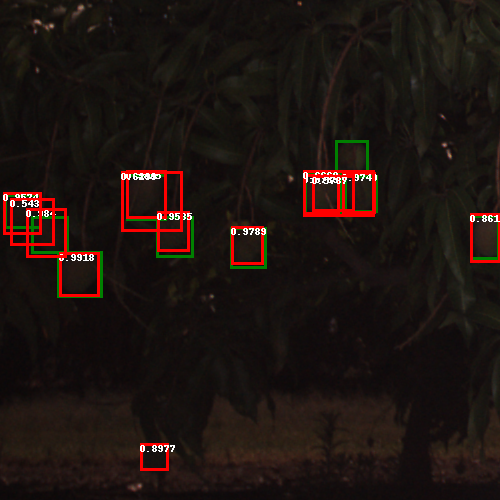

In [94]:
idx = 200
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# Draw groundtruth box in Green
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])],
   outline ="green", width =3)

#Draw prediction box in Red
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)

   #Drawing prediction boxes above a certain confidence threshold
   if score > 0.5:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image

In [97]:
import torch
import numpy as np
from PIL import Image, ImageDraw

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    # TODO: Replace the following line with the preprocessing steps used for your model
    image = image.resize((256, 256))  # Example: Resize to the expected input size
    image_tensor = torch.from_numpy(np.array(image)).float()
    image_tensor = image_tensor.permute(2, 0, 1) / 255  # Convert to CHW format and normalize
    return image_tensor

# Path to your external image
external_image_path = '/content/drive/MyDrive/mangoes/download (2).png'

# Load and preprocess the image
img = load_image(external_image_path)

# Put the model in evaluation mode and make a prediction
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

# Convert the image from tensor to PIL format for drawing
image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(image)

# Draw predicted boxes in red
for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals=4)

    if score > 0.5:  # Drawing boxes with confidence > 0.5
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                       outline="red", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score))

# Display the image
image.show()


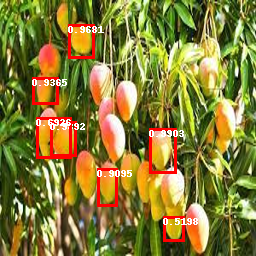

In [99]:
from IPython.display import display

# ... [rest of your code] ...

# Display the image
display(image)
